In [1]:
import os
import cv2
import tqdm
import time
import itertools
import numpy as np
from math import ceil
from itertools import chain
from tqdm.contrib import tzip
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' ## also i can install nomkl
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [56]:
%run ./data_utils.ipynb
%run ./segnet_model.ipynb

In [5]:
BATCH_SIZE = 12
NUM_INPUT_CHANNELS = 3
NUM_OUTPUT_CHANNELS = 32
NUM_CLASSES = 32
NUM_EPOCHS = 60
LEARNING_RATE = 0.04
MOMENTUM = 0.9

In [6]:
transform = T.Compose([
            T.ToPILImage(),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

Images size: (720, 960, 3)


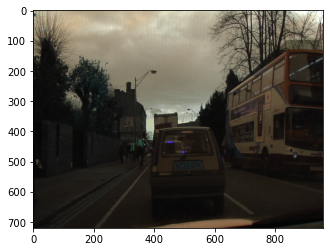

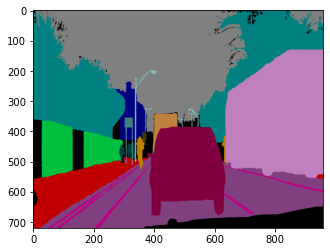

  0%|          | 0/702 [00:00<?, ?it/s]

data size:	 700 700
X_train:	training images shape	 406 (210, 280, 3)
X_test:		test images shape	 294 (210, 280, 3)
Y_train:	training labels shape	 406 (210, 280)
Y_test:		test labels shape	 294 (210, 280)


In [7]:
data_reader = Data_reader(DATA_PATH = '../../data/part_A/camvid/')
X_train, X_test, Y_train, Y_test = data_reader.load_data(data_shape_log = True)

In [8]:
train_data = CamvidDataset(X_train, Y_train, transform = transform)
test_data = CamvidDataset(X_test[:30], Y_test[:30], transform = transform)
eval_data = CamvidDataset(X_test[30:], Y_test[30:], transform = transform)

print('train set:\t', len(train_data))
print('test set:\t', len(test_data))
print('eval set:\t', len(eval_data))

train set:	 406
test set:	 30
eval set:	 264


In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 10, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, shuffle = False)

batch of images shape torch.Size([10, 3, 210, 280])
batch of labels shape torch.Size([10, 210, 280])


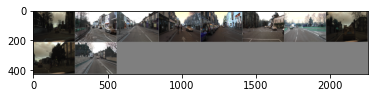

In [10]:
dataiter = iter(train_loader)
images, label = dataiter.next()
print('batch of images shape', images.shape)
print('batch of labels shape', label.shape)
imshow(torchvision.utils.make_grid(images))

In [11]:
model = SegNetBase(NUM_INPUT_CHANNELS, NUM_OUTPUT_CHANNELS)

c = data_reader.labels_probability()
c[c < 1e-6] = 1e-6
class_weights = 1.0/c
criterion = torch.nn.CrossEntropyLoss(weight = class_weights)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [12]:
losses, t_losses = train(model, criterion, optimizer, NUM_EPOCHS = NUM_EPOCHS, load = False)

Epochs:	 60
batch loss: 3.470414876937866
batch loss: 3.449159622192383
batch loss: 3.4554128646850586
batch loss: 3.454819917678833
batch loss: 3.470252752304077
batch loss: 3.457634449005127
batch loss: 3.4625186920166016
batch loss: 3.4490835666656494
batch loss: 3.4453446865081787
batch loss: 3.4425201416015625
batch loss: 3.482933759689331
batch loss: 3.4613990783691406
batch loss: 3.4391043186187744
batch loss: 3.4792168140411377
batch loss: 3.4813854694366455
batch loss: 3.450631856918335
batch loss: 3.4475414752960205
batch loss: 3.4466552734375
batch loss: 3.444031000137329
batch loss: 3.4818811416625977
batch loss: 3.455493688583374
batch loss: 3.455867290496826
batch loss: 3.441718816757202
batch loss: 3.434168815612793
batch loss: 3.437453031539917
batch loss: 3.439903974533081
batch loss: 3.356125831604004
batch loss: 3.4395971298217773
batch loss: 3.462585926055908
batch loss: 3.4660608768463135
batch loss: 3.434030294418335
batch loss: 3.455254077911377
batch loss: 3.435

batch loss: 3.17189621925354
batch loss: 2.7664124965667725
batch loss: 2.851170063018799
batch loss: 2.9135563373565674
batch loss: 2.818131446838379
batch loss: 3.1019392013549805
batch loss: 2.8129079341888428
batch loss: 3.0103185176849365
batch loss: 3.0431571006774902
batch loss: 3.031804084777832
batch loss: 2.904623031616211
batch loss: 2.9194211959838867
batch loss: 2.8402161598205566
batch loss: 2.977483034133911
batch loss: 2.9590563774108887
batch loss: 2.9326233863830566
batch loss: 2.5971713066101074
batch loss: 2.8516314029693604
batch loss: 2.873121976852417
batch loss: 2.9056503772735596
batch loss: 2.816582441329956
batch loss: 2.836156129837036
batch loss: 2.446323871612549
batch loss: 2.828188419342041
batch loss: 2.84781813621521
batch loss: 2.908625841140747
batch loss: 2.772627830505371
batch loss: 2.2634027004241943
batch loss: 2.815120220184326
batch loss: 2.6009109020233154
batch loss: 2.866245985031128
batch loss: 2.1794073581695557
batch loss: 3.057735204696

batch loss: 2.240142583847046
batch loss: 2.6136419773101807
batch loss: 2.1805930137634277
batch loss: 2.740631580352783
batch loss: 2.5787646770477295
batch loss: 2.4302492141723633
batch loss: 2.603565216064453
batch loss: 2.042057752609253
batch loss: 2.4949607849121094
batch loss: 2.4831173419952393
batch loss: 2.449751377105713
batch loss: 2.3256208896636963
batch loss: 2.4654104709625244
batch loss: 2.5227346420288086
batch loss: 1.7000724077224731
batch loss: 2.0939550399780273
batch loss: 2.837172746658325
batch loss: 2.3060719966888428
batch loss: 2.1516964435577393
batch loss: 2.085716962814331
batch loss: 2.694837808609009
batch loss: 2.3243186473846436
batch loss: 2.5970494747161865
batch loss: 2.4875974655151367
Epoch #13	train loss: 2.40027803	test loss: 2.44741416	 Time: 3714.700764s
batch loss: 2.5803442001342773
batch loss: 2.6010000705718994
batch loss: 2.2960681915283203
batch loss: 2.6155154705047607
batch loss: 2.5420515537261963
batch loss: 2.1931982040405273
bat

batch loss: 1.9473313093185425
batch loss: 1.8922410011291504
batch loss: 2.1861379146575928
batch loss: 2.23775577545166
batch loss: 2.309087038040161
batch loss: 2.249807357788086
batch loss: 2.038599729537964
batch loss: 2.1813862323760986
batch loss: 2.178165912628174
batch loss: 1.7423139810562134
batch loss: 2.155379295349121
batch loss: 1.8594558238983154
batch loss: 2.1141884326934814
batch loss: 2.118285655975342
batch loss: 1.4930195808410645
batch loss: 1.9447603225708008
Epoch #19	train loss: 2.05093838	test loss: 2.10027528	 Time: 1238.031939s
batch loss: 2.228072166442871
batch loss: 1.7677743434906006
batch loss: 2.1476104259490967
batch loss: 1.8856382369995117
batch loss: 2.178095579147339
batch loss: 2.0340254306793213
batch loss: 2.1270644664764404
batch loss: 2.1071245670318604
batch loss: 2.0367367267608643
batch loss: 2.093371629714966
batch loss: 1.8940985202789307
batch loss: 1.4214097261428833
batch loss: 2.028247117996216
batch loss: 1.9233053922653198
batch l

batch loss: 1.5311517715454102
batch loss: 1.686193585395813
batch loss: 1.6464935541152954
batch loss: 1.6307287216186523
batch loss: 1.2437599897384644
batch loss: 1.7052472829818726
batch loss: 1.5807791948318481
batch loss: 1.9338022470474243
batch loss: 1.9592411518096924
Epoch #25	train loss: 1.80893597	test loss: 1.83006883	 Time: 649.529629s
batch loss: 1.892616868019104
batch loss: 1.9943006038665771
batch loss: 1.6945313215255737
batch loss: 1.4258743524551392
batch loss: 1.9336618185043335
batch loss: 1.945678949356079
batch loss: 1.8010672330856323
batch loss: 1.943544864654541
batch loss: 1.4851384162902832
batch loss: 1.7551568746566772
batch loss: 1.816881775856018
batch loss: 1.6371768712997437
batch loss: 1.9647419452667236
batch loss: 1.6657474040985107
batch loss: 2.33491587638855
batch loss: 1.676182508468628
batch loss: 1.90985107421875
batch loss: 1.8770134449005127
batch loss: 1.8742061853408813
batch loss: 1.5951594114303589
batch loss: 1.8423514366149902
batch 

batch loss: 1.5263105630874634
batch loss: 1.6362829208374023
Epoch #31	train loss: 1.61402246	test loss: 1.64610088	 Time: 653.980304s
batch loss: 1.853695034980774
batch loss: 1.501774787902832
batch loss: 1.3282498121261597
batch loss: 1.8135920763015747
batch loss: 1.4370404481887817
batch loss: 1.5700010061264038
batch loss: 1.5891140699386597
batch loss: 1.3615790605545044
batch loss: 1.511205792427063
batch loss: 1.610816240310669
batch loss: 1.8146462440490723
batch loss: 2.1339004039764404
batch loss: 1.4390060901641846
batch loss: 1.3189070224761963
batch loss: 1.3934656381607056
batch loss: 1.625011920928955
batch loss: 1.1666690111160278
batch loss: 1.321534276008606
batch loss: 1.3634458780288696
batch loss: 1.7935782670974731
batch loss: 1.5162312984466553
batch loss: 1.3627984523773193
batch loss: 1.6086163520812988
batch loss: 1.883186936378479
batch loss: 1.3743715286254883
batch loss: 1.8093641996383667
batch loss: 1.764894723892212
batch loss: 2.2155725955963135
batc

batch loss: 1.0917301177978516
batch loss: 1.6048429012298584
batch loss: 1.3615381717681885
batch loss: 1.5326651334762573
batch loss: 1.4576294422149658
batch loss: 0.9307085275650024
batch loss: 1.4415053129196167
batch loss: 1.3908207416534424
batch loss: 1.6677857637405396
batch loss: 1.3873353004455566
batch loss: 1.8942992687225342
batch loss: 1.4874643087387085
batch loss: 1.4378811120986938
batch loss: 1.3744078874588013
batch loss: 1.48173189163208
batch loss: 1.3693832159042358
batch loss: 1.356859803199768
batch loss: 1.600572109222412
batch loss: 1.4589953422546387
batch loss: 1.48872971534729
batch loss: 1.654283046722412
batch loss: 1.8939701318740845
batch loss: 1.5797710418701172
batch loss: 1.6928905248641968
batch loss: 1.659288763999939
batch loss: 1.6375399827957153
batch loss: 1.0422228574752808
batch loss: 1.415001392364502
batch loss: 1.7032114267349243
batch loss: 1.5457289218902588
batch loss: 1.5498230457305908
batch loss: 1.333455204963684
batch loss: 1.8522

batch loss: 1.2911874055862427
batch loss: 1.5515384674072266
batch loss: 1.2946676015853882
batch loss: 1.534537434577942
batch loss: 1.1963613033294678
batch loss: 1.4502229690551758
batch loss: 1.3255410194396973
batch loss: 1.2986582517623901
batch loss: 1.2637884616851807
batch loss: 1.6861222982406616
batch loss: 1.0636824369430542
batch loss: 1.2721349000930786
batch loss: 1.3707525730133057
batch loss: 1.3766182661056519
batch loss: 1.5240976810455322
batch loss: 1.3439522981643677
batch loss: 1.6950194835662842
batch loss: 1.2337284088134766
batch loss: 1.3029844760894775
batch loss: 1.3410344123840332
batch loss: 1.6585196256637573
batch loss: 1.4185720682144165
batch loss: 1.2341649532318115
batch loss: 1.3938895463943481
batch loss: 1.4385195970535278
batch loss: 1.483491063117981
batch loss: 1.3133800029754639
batch loss: 1.3691314458847046
batch loss: 1.2534611225128174
batch loss: 1.5428204536437988
batch loss: 1.3240675926208496
batch loss: 1.329066276550293
Epoch #44	t

batch loss: 1.237383246421814
batch loss: 1.3185498714447021
batch loss: 1.0926942825317383
batch loss: 1.4187917709350586
batch loss: 1.180901288986206
batch loss: 1.3564367294311523
batch loss: 1.458298921585083
batch loss: 1.0980159044265747
batch loss: 0.8838595747947693
batch loss: 1.2735663652420044
batch loss: 1.4286261796951294
batch loss: 1.1912447214126587
batch loss: 1.2341891527175903
batch loss: 1.3409026861190796
batch loss: 0.9569308161735535
batch loss: 1.192065954208374
batch loss: 1.2481416463851929
batch loss: 1.1103827953338623
batch loss: 1.0007489919662476
batch loss: 1.2726800441741943
batch loss: 1.077428936958313
batch loss: 1.3299936056137085
batch loss: 1.1708005666732788
batch loss: 1.3927664756774902
batch loss: 1.1494133472442627
batch loss: 1.2554669380187988
Epoch #50	train loss: 1.24327438	test loss: 1.32737517	 Time: 646.237785s
batch loss: 1.2734209299087524
batch loss: 1.2570792436599731
batch loss: 1.2419434785842896
batch loss: 1.1417745351791382
b

batch loss: 1.2948591709136963
batch loss: 1.3562147617340088
batch loss: 1.0475322008132935
batch loss: 1.2757682800292969
batch loss: 1.3261981010437012
batch loss: 1.1998817920684814
batch loss: 1.1102780103683472
batch loss: 1.0757383108139038
batch loss: 1.209668755531311
batch loss: 0.9684251546859741
batch loss: 1.1975170373916626
batch loss: 1.2609158754348755
batch loss: 1.2024332284927368
batch loss: 1.2146975994110107
batch loss: 1.197999358177185
batch loss: 1.2108211517333984
batch loss: 1.1635545492172241
batch loss: 1.3589075803756714
batch loss: 1.2647420167922974
batch loss: 1.1305829286575317
Epoch #56	train loss: 1.19313826	test loss: 1.28298056	 Time: 650.634217s
batch loss: 1.2689319849014282
batch loss: 1.1707537174224854
batch loss: 1.1487841606140137
batch loss: 1.056546688079834
batch loss: 0.9591251611709595
batch loss: 1.1502926349639893
batch loss: 1.1475032567977905
batch loss: 1.411760926246643
batch loss: 1.1331005096435547
batch loss: 1.2072428464889526


In [48]:
losses2, t_losses2 = train(None, criterion, optimizer, NUM_EPOCHS = 20, log = True, load = True)

Epochs:	 20
batch loss: 1.1259664297103882
batch loss: 1.2317191362380981
batch loss: 1.0018786191940308
batch loss: 1.1548066139221191
batch loss: 0.8968542218208313
batch loss: 1.0671242475509644
batch loss: 1.1290125846862793
batch loss: 0.9542574882507324
batch loss: 1.090885877609253
batch loss: 1.3351118564605713
batch loss: 1.0576022863388062
batch loss: 1.1813509464263916
batch loss: 1.3358218669891357
batch loss: 1.0837044715881348
batch loss: 1.1794466972351074
batch loss: 1.1617214679718018
batch loss: 1.501476526260376
batch loss: 0.9417840242385864
batch loss: 1.0317134857177734
batch loss: 0.8983104825019836
batch loss: 1.131290316581726
batch loss: 1.057067632675171
batch loss: 1.186828374862671
batch loss: 1.106906533241272
batch loss: 1.546182632446289
batch loss: 0.7163756489753723
batch loss: 1.1333258152008057
batch loss: 0.9247459769248962
batch loss: 1.0432393550872803
batch loss: 1.1754652261734009
batch loss: 1.1660401821136475
batch loss: 1.2242341041564941
bat

batch loss: 1.1413683891296387
batch loss: 1.1721818447113037
batch loss: 1.1472314596176147
batch loss: 1.0729765892028809
batch loss: 0.9377681016921997
batch loss: 1.2276791334152222
batch loss: 1.2453933954238892
batch loss: 1.2004611492156982
batch loss: 1.036027193069458
batch loss: 1.07355535030365
batch loss: 1.2197860479354858
batch loss: 1.1230734586715698
batch loss: 1.0466090440750122
batch loss: 1.1167199611663818
batch loss: 1.4430861473083496
batch loss: 1.1853245496749878
batch loss: 1.8565242290496826
batch loss: 0.9499689936637878
batch loss: 1.0596377849578857
batch loss: 0.9823086857795715
batch loss: 1.0979633331298828
batch loss: 1.5166242122650146
batch loss: 0.8406372666358948
batch loss: 1.0281440019607544
batch loss: 1.153771996498108
batch loss: 1.167923092842102
batch loss: 1.1394951343536377
batch loss: 1.0705516338348389
batch loss: 0.9484580755233765
batch loss: 1.1872740983963013
batch loss: 1.1197443008422852
batch loss: 1.1467856168746948
batch loss: 1

batch loss: 0.8796460032463074
batch loss: 1.0717746019363403
batch loss: 1.0577112436294556
batch loss: 1.279392957687378
batch loss: 1.1623458862304688
batch loss: 1.049264907836914
batch loss: 1.0321671962738037
batch loss: 1.161677598953247
batch loss: 1.1266707181930542
batch loss: 1.632216215133667
batch loss: 1.0926170349121094
batch loss: 0.9336383938789368
batch loss: 1.1480175256729126
batch loss: 1.1615856885910034
batch loss: 1.085031509399414
batch loss: 1.1829853057861328
batch loss: 1.03213369846344
batch loss: 1.1374770402908325
batch loss: 1.0912073850631714
batch loss: 1.0693000555038452
batch loss: 1.12690007686615
batch loss: 1.2233120203018188
batch loss: 0.8747100234031677
batch loss: 1.0265620946884155
batch loss: 0.9871525168418884
batch loss: 1.085964322090149
batch loss: 1.3732903003692627
batch loss: 1.156563639640808
batch loss: 1.1944936513900757
Epoch #13	train loss: 1.11615773	test loss: 1.20430911	 Time: 644.870709s
batch loss: 0.8999864459037781
batch l

batch loss: 1.1401289701461792
batch loss: 1.059386134147644
batch loss: 1.0830309391021729
batch loss: 1.1723438501358032
batch loss: 1.1295852661132812
batch loss: 0.8574997186660767
batch loss: 1.1305721998214722
batch loss: 1.165767788887024
batch loss: 1.1549110412597656
batch loss: 1.0722206830978394
batch loss: 1.0886917114257812
batch loss: 1.1300920248031616
batch loss: 1.378312110900879
batch loss: 1.2140557765960693
batch loss: 1.1612341403961182
batch loss: 1.077651023864746
batch loss: 1.048574447631836
batch loss: 1.2046133279800415
batch loss: 0.9640582203865051
batch loss: 1.094041347503662
batch loss: 1.1963980197906494
batch loss: 1.026300311088562
Epoch #19	train loss: 1.12769934	test loss: 1.20430911	 Time: 656.986022s
batch loss: 1.2406147718429565
batch loss: 1.0097919702529907
batch loss: 0.9090082049369812
batch loss: 1.0795578956604004
batch loss: 1.135412335395813
batch loss: 1.6404941082000732
batch loss: 1.0845414400100708
batch loss: 1.077080488204956
batch

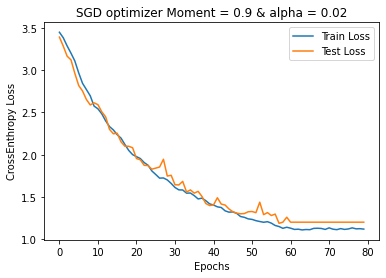

In [52]:
plt.plot([i for i in range(len(losses))], losses, label='Train Loss')
plt.plot([i for i in range(80)], t_losses, label = 'Test Loss')
plt.xlabel('Epochs')
plt.ylabel('CrossEnthropy Loss')
plt.title('SGD optimizer Moment = 0.9 & alpha = 0.02')
plt.legend()

plt.show()

In [58]:
train_loader0 = torch.utils.data.DataLoader(train_data, batch_size = 1, shuffle=True, pin_memory=True)
imagesTrain, labelsTrain, resultsTrain, correctnessesTrain = val(train_loader0, model_path = './model_best.pth')

In [61]:
imagesTest, labelsTest, resultsTest, correctnessesTest = val(test_loader, model_path = './model_best.pth')

Evaluating the method on train data:
Correctness:	 0.8565209


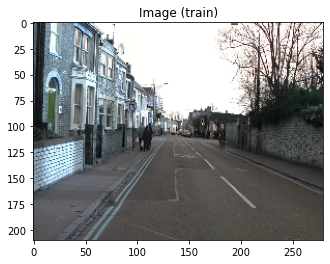

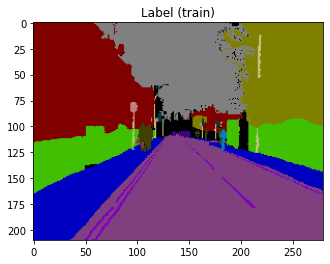

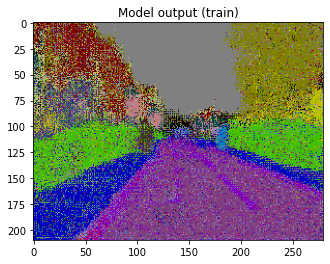

In [62]:
print('Evaluating the method on train data:')
print('Correctness:\t', np.array(correctnessesTrain).mean())

imshow(imagesTrain[3][0], 'Image (train)')

plt.imshow(data_reader.rev_translate(np.array([labelsTrain[3]])))
plt.title('Label (train)')
plt.show()

plt.imshow(resultsTrain[3])
plt.title('Model output (train)')
plt.show()

Evaluating the method on test data:
Correctness:	 0.8470986


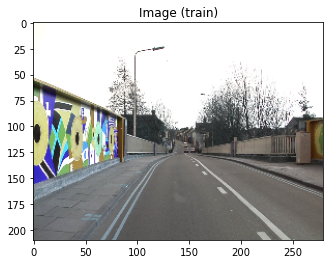

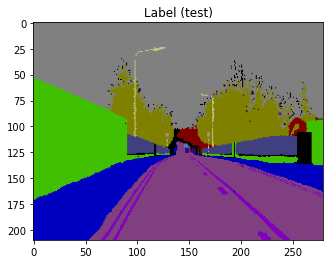

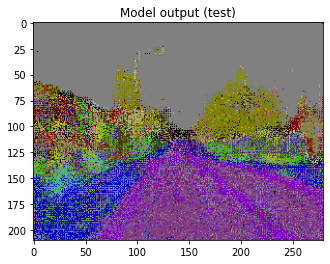

In [63]:
print('Evaluating the method on test data:')
print('Correctness:\t', np.array(correctnessesTest).mean())

imshow(imagesTest[4][0], 'Image (train)')

plt.imshow(data_reader.rev_translate(np.array([labelsTest[4]])))
plt.title('Label (test)')
plt.show()

plt.imshow(resultsTest[4])
plt.title('Model output (test)')
plt.show()